In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import functools
import matplotlib.pyplot as plt

from datasets.shapenet_data_pc import ShapeNet15kPointClouds


from modules.se import SE3d
from modules.ball_query import BallQuery
from modules.shared_mlp import SharedMLP
from modules.voxelization import Voxelization
import modules.functional as F

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig

# Prepare Datasets and DataLoaders

In [3]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


In [4]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=50, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=50, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [5]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(2832, 405, 808)

# Define PVCNN Architecture

In [6]:
class PointNetAModule(nn.Module):
    def __init__(self, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]]
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels]

        mlps = []
        total_out_channels = 0
        for _out_channels in out_channels:
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=1)
            )
            total_out_channels += _out_channels[-1]

        self.include_coordinates = include_coordinates
        self.out_channels = total_out_channels
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        if self.include_coordinates:
            features = torch.cat([features, coords], dim=1)
        coords = torch.zeros((coords.size(0), 3, 1), device=coords.device)
        if len(self.mlps) > 1:
            features_list = []
            for mlp in self.mlps:
                features_list.append(mlp(features).max(dim=-1, keepdim=True).values)
            return torch.cat(features_list, dim=1), coords
        else:
            return self.mlps[0](features).max(dim=-1, keepdim=True).values, coords

    def extra_repr(self):
        return f'out_channels={self.out_channels}, include_coordinates={self.include_coordinates}'


class PointNetSAModule(nn.Module):
    def __init__(self, num_centers, radius, num_neighbors, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(radius, (list, tuple)):
            radius = [radius]
        if not isinstance(num_neighbors, (list, tuple)):
            num_neighbors = [num_neighbors] * len(radius)
        assert len(radius) == len(num_neighbors)
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]] * len(radius)
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels] * len(radius)
        assert len(radius) == len(out_channels)

        groupers, mlps = [], []
        total_out_channels = 0
        for _radius, _out_channels, _num_neighbors in zip(radius, out_channels, num_neighbors):
            groupers.append(
                BallQuery(radius=_radius, num_neighbors=_num_neighbors, include_coordinates=include_coordinates)
            )
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=2)
            )
            total_out_channels += _out_channels[-1]

        self.num_centers = num_centers
        self.out_channels = total_out_channels
        self.groupers = nn.ModuleList(groupers)
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        centers_coords = F.furthest_point_sample(coords, self.num_centers)
        features_list = []
        for grouper, mlp in zip(self.groupers, self.mlps):
            features_list.append(mlp(grouper(coords, centers_coords, features)).max(dim=-1).values)
        if len(features_list) > 1:
            return torch.cat(features_list, dim=1), centers_coords
        else:
            return features_list[0], centers_coords

    def extra_repr(self):
        return f'num_centers={self.num_centers}, out_channels={self.out_channels}'


class PointNetFPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = SharedMLP(in_channels=in_channels, out_channels=out_channels, dim=1)

    def forward(self, inputs):
        if len(inputs) == 3:
            points_coords, centers_coords, centers_features = inputs
            points_features = None
        else:
            points_coords, centers_coords, centers_features, points_features = inputs
        interpolated_features = F.nearest_neighbor_interpolate(points_coords, centers_coords, centers_features)
        if points_features is not None:
            interpolated_features = torch.cat(
                [interpolated_features, points_features], dim=1
            )
        return self.mlp(interpolated_features), points_coords

In [7]:
class PVConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, resolution, with_se=False, normalize=True, eps=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.resolution = resolution

        self.voxelization = Voxelization(resolution, normalize=normalize, eps=eps)
        voxel_layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
            nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
         ]
        if with_se:
            voxel_layers.append(SE3d(out_channels))
        self.voxel_layers = nn.Sequential(*voxel_layers)
        self.point_features = SharedMLP(in_channels, out_channels)

    def forward(self, inputs):
        features, coords = inputs
        voxel_features, voxel_coords = self.voxelization(features, coords)
        voxel_features = self.voxel_layers(voxel_features)
        voxel_features = F.trilinear_devoxelize(voxel_features, voxel_coords, self.resolution, self.training)
        fused_features = voxel_features + self.point_features(features)
        return fused_features, coords

In [8]:
def _linear_bn_relu(in_channels, out_channels):
    return nn.Sequential(nn.Linear(in_channels, out_channels), nn.BatchNorm1d(out_channels), nn.ReLU(True))


def create_mlp_components(in_channels, out_channels, classifier=False, dim=2, width_multiplier=1):
    r = width_multiplier

    if dim == 1:
        block = _linear_bn_relu
    else:
        block = SharedMLP
    if not isinstance(out_channels, (list, tuple)):
        out_channels = [out_channels]
    if len(out_channels) == 0 or (len(out_channels) == 1 and out_channels[0] is None):
        return nn.Sequential(), in_channels, in_channels

    layers = []
    for oc in out_channels[:-1]:
        if oc < 1:
            layers.append(nn.Dropout(oc))
        else:
            oc = int(r * oc)
            layers.append(block(in_channels, oc))
            in_channels = oc
    if dim == 1:
        if classifier:
            layers.append(nn.Linear(in_channels, out_channels[-1]))
        else:
            layers.append(_linear_bn_relu(in_channels, int(r * out_channels[-1])))
    else:
        if classifier:
            layers.append(nn.Conv1d(in_channels, out_channels[-1], 1))
        else:
            layers.append(SharedMLP(in_channels, int(r * out_channels[-1])))
    return layers, out_channels[-1] if classifier else int(r * out_channels[-1])


def create_pointnet_components(blocks, in_channels, with_se=False, normalize=True, eps=0,
                               width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    layers, concat_channels = [], 0
    for out_channels, num_blocks, voxel_resolution in blocks:
        out_channels = int(r * out_channels)
        if voxel_resolution is None:
            block = SharedMLP
        else:
            block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                      with_se=with_se, normalize=normalize, eps=eps)
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels))
            in_channels = out_channels
            concat_channels += out_channels
    return layers, in_channels, concat_channels


def create_pointnet2_sa_components(sa_blocks, extra_feature_channels, with_se=False, normalize=True, eps=0,
                                   width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier
    in_channels = extra_feature_channels + 3

    sa_layers, sa_in_channels = [], []
    for conv_configs, sa_configs in sa_blocks:
        sa_in_channels.append(in_channels)
        sa_blocks = []
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                sa_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
            extra_feature_channels = in_channels
        num_centers, radius, num_neighbors, out_channels = sa_configs
        _out_channels = []
        for oc in out_channels:
            if isinstance(oc, (list, tuple)):
                _out_channels.append([int(r * _oc) for _oc in oc])
            else:
                _out_channels.append(int(r * oc))
        out_channels = _out_channels
        if num_centers is None:
            block = PointNetAModule
        else:
            block = functools.partial(PointNetSAModule, num_centers=num_centers, radius=radius,
                                      num_neighbors=num_neighbors)
        sa_blocks.append(block(in_channels=extra_feature_channels, out_channels=out_channels,
                               include_coordinates=True))
        in_channels = extra_feature_channels = sa_blocks[-1].out_channels
        if len(sa_blocks) == 1:
            sa_layers.append(sa_blocks[0])
        else:
            sa_layers.append(nn.Sequential(*sa_blocks))

    return sa_layers, sa_in_channels, in_channels, 1 if num_centers is None else num_centers


def create_pointnet2_fp_modules(fp_blocks, in_channels, sa_in_channels, with_se=False, normalize=True, eps=0,
                                width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    fp_layers = []
    for fp_idx, (fp_configs, conv_configs) in enumerate(fp_blocks):
        fp_blocks = []
        out_channels = tuple(int(r * oc) for oc in fp_configs)
        fp_blocks.append(
            PointNetFPModule(in_channels=in_channels + sa_in_channels[-1 - fp_idx], out_channels=out_channels)
        )
        in_channels = out_channels[-1]
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                fp_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
        if len(fp_blocks) == 1:
            fp_layers.append(fp_blocks[0])
        else:
            fp_layers.append(nn.Sequential(*fp_blocks))

    return fp_layers, in_channels

In [9]:
class PVCNN(nn.Module):
    blocks = ((64, 1, 32), (128, 2, 16), (512, 1, None), (2048, 1, None))

    def __init__(self, num_classes, num_shapes, extra_feature_channels=3,
                 width_multiplier=1, voxel_resolution_multiplier=1):
        super().__init__()
        assert extra_feature_channels >= 0
        self.in_channels = extra_feature_channels + 3
        self.num_shapes = num_shapes

        layers, channels_point, concat_channels_point = create_pointnet_components(
            blocks=self.blocks, in_channels=self.in_channels, with_se=True, normalize=False,
            width_multiplier=width_multiplier, voxel_resolution_multiplier=voxel_resolution_multiplier
        )
        self.point_features = nn.ModuleList(layers)

        layers, _ = create_mlp_components(in_channels=(num_shapes + channels_point + concat_channels_point),
                                          out_channels=[256, 0.2, 256, 0.2, 128, num_classes],
                                          classifier=True, dim=2, width_multiplier=width_multiplier)
        self.classifier = nn.Sequential(*layers)

    def forward(self, inputs):
        # inputs : [B, in_channels + S, N]
        features = inputs[:, :self.in_channels, :]
        one_hot_vectors = inputs[:, -self.num_shapes:, :]
        num_points = features.size(-1)

        coords = features[:, :3, :]
        out_features_list = [one_hot_vectors]
        for i in range(len(self.point_features)):
            features, _ = self.point_features[i]((features, coords))
            out_features_list.append(features)
        out_features_list.append(features.max(dim=-1, keepdim=True).values.repeat([1, 1, num_points]))
        return self.classifier(torch.cat(out_features_list, dim=1))

In [16]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

# Let's train the PVCNN

In [32]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [40]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

training_losses = []
val_losses = []

for epoch in range(30):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda").transpose(1,2)
        optimizer.zero_grad()
        output = model(input).to("cuda")
        loss = chamfer_distance(input, output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda").transpose(1,2)
            output = model(input).to("cuda")
            val_loss = chamfer_distance(input, output)

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Save the model
    model_save_path = f"output-models/PVCNN-Baseline-Reconstructon-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

Epoch 0,  Training Loss: 33.6602, Validation Loss: 3.2977
Model saved to PVCNN-Baseline-e0.pth
Epoch 1,  Training Loss: 19.7296, Validation Loss: 3.4352
Model saved to PVCNN-Baseline-e1.pth
Epoch 2,  Training Loss: 16.5799, Validation Loss: 2.4288
Model saved to PVCNN-Baseline-e2.pth
Epoch 3,  Training Loss: 14.5900, Validation Loss: 2.0490
Model saved to PVCNN-Baseline-e3.pth
Epoch 4,  Training Loss: 13.0419, Validation Loss: 1.6544
Model saved to PVCNN-Baseline-e4.pth
Epoch 5,  Training Loss: 12.0337, Validation Loss: 1.2136
Model saved to PVCNN-Baseline-e5.pth
Epoch 6,  Training Loss: 11.1920, Validation Loss: 1.3941
Model saved to PVCNN-Baseline-e6.pth
Epoch 7,  Training Loss: 10.5124, Validation Loss: 1.2498
Model saved to PVCNN-Baseline-e7.pth
Epoch 8,  Training Loss: 10.0419, Validation Loss: 1.3331
Model saved to PVCNN-Baseline-e8.pth
Epoch 9,  Training Loss: 9.5359, Validation Loss: 1.4709
Model saved to PVCNN-Baseline-e9.pth
Epoch 10,  Training Loss: 9.1731, Validation Loss: 

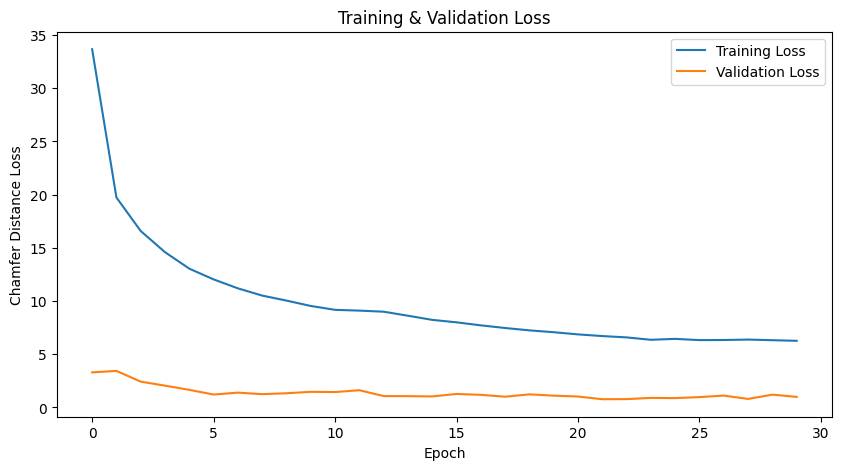

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

# Let's visualize some examples

In [10]:
# Run this if you need to load the model.

model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load("output-models/PVCNN-Baseline-e29.pth"))

<All keys matched successfully>

In [18]:
model.eval()

with torch.no_grad():
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda").transpose(1,2)
        output = model(input).to("cuda")
        break

In [ ]:
i = 1
for gt, output_pvcnn in zip(input, output):
    input_np = gt.squeeze().transpose(0, 1).detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().transpose(0, 1).detach().cpu().numpy()


    output_np = rotate_point_cloud_z(output_np, 90)
    output_np = rotate_point_cloud_y(output_np, 90)

    fig = visualize_pointcloud_eval(input_np, output_np, "ShapeNet Ground Truth", "PVCNN Reconstruction")
    save_fig(fig, f"./eval-results/pvcnn-reconstruction/train-example-{i}.jpg")

    i += 1

# Evaluate the trained PVCNN

In [17]:
model.eval()

total_train_loss = 0

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda").transpose(1,2)
        output = model(input).to("cuda")
        
        loss = chamfer_distance(input, output)
        total_train_loss += loss.item()
        print(f"Batch {i}, CD Loss: {loss.item():.4f}")

average_loss = total_train_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

Batch 0, CD Loss: 2.5815
Batch 1, CD Loss: 2.1783
Batch 2, CD Loss: 3.8621
Batch 3, CD Loss: 2.9470
Batch 4, CD Loss: 2.5729
Batch 5, CD Loss: 2.3896
Batch 6, CD Loss: 2.5309
Batch 7, CD Loss: 2.6944
Batch 8, CD Loss: 3.0185
Batch 9, CD Loss: 2.6764
Batch 10, CD Loss: 2.5640
Batch 11, CD Loss: 3.0590
Batch 12, CD Loss: 3.3092
Batch 13, CD Loss: 3.1094
Batch 14, CD Loss: 2.3401
Batch 15, CD Loss: 2.1908
TOTAL CD Loss: 2.7515


# Let's visualize some more examples from the test set

In [20]:
model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        input = batch["train_points"].to("cuda").transpose(1,2)
        output = model(input).to("cuda")
        break

In [ ]:
i = 1
for gt, output_pvcnn in zip(input, output):
    input_np = gt.squeeze().transpose(0, 1).detach().cpu().numpy()
    output_np = output_pvcnn.squeeze().transpose(0, 1).detach().cpu().numpy()


    output_np = rotate_point_cloud_z(output_np, 90)
    output_np = rotate_point_cloud_y(output_np, 90)

    fig = visualize_pointcloud_eval(input_np, output_np, "ShapeNet Ground Truth", "PVCNN Reconstruction")
    save_fig(fig, f"./eval-results/pvcnn-reconstruction/test-example-{i}.jpg")

    i += 1

# Final Results

### Training (Last Epoch)
- Training CD Loss: 6.2621
- Validation CD Loss: 0.9939

### Evaluation
- CD Loss: 2.7515